In [1]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import stable_baselines3
import time

In [2]:
# Print Versioning
print("Gym version", gym.__version__)
print("Numpy version", np.__version__)
print("Stable Baselines3 version", stable_baselines3.__version__)

Gym version 1.1.1
Numpy version 2.2.5
Stable Baselines3 version 2.6.0


In [3]:
# Set initial condition function here
def getInitialCondition(X, nx):
    xScale = np.linspace(0, X, nx)
    c0 = 0.8 * 1e5 * np.exp(-0.25 * (xScale ** 2))
    return c0

In [4]:
# Timestep and spatial step for PDE Solver
T = 600
X = 200
dt = 1
dx = 1

In [5]:
from pde_control_gym.src import BrainTumorReward

Parameters = {
  "T": T,
  "X": X,
  "dt": dt,
  "dx": dx,
  "reward_class": BrainTumorReward,
  "normalize": True,
  "D": 0.2,
  "rho": 0.03,
  "alpha": 0.04,
  "alpha_beta_ratio": 10,
  "k": 1e5,
  "t1_detection_radius": 15,
  "t1_death_radius": 35,
  "reset_init_condition_func": getInitialCondition,

  "benchmark": None,
  "total_dosage": 61.2 # what the action controls the use of
}


In [6]:
def runSingleEpisode(openLoopController, RLController, env, parameter, ):
    terminate = False
    truncate = False

    useRLController = False

    # Holds the resulting states
    uStorage = []
    rew = 0

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    while not truncate and not terminate:
        if useRLController:
            print("use RLController")
            action = RLController(obs, parameter)
        else:
            print("use openLoopController")
            action = openLoopController(obs, parameter)
        obs, rewards, terminate, truncate, info = env.step(action)

        stage = info.get("stage")
        if stage == "Growth" or stage == "Post-Therapy":
            useRLController = False
        else: #stage == "Therapy"
            useRLController = True

        uStorage.append(obs)
        rew += rewards 

    u = np.array(uStorage)
    return rew, u


def openLoopController(_, _a):
    return 0

def RLController(obs, model):
    action, _state = model.predict(obs)
    return action

In [7]:
openLoopParameters = Parameters.copy()
openLoopParameters["benchmark"] = True
envOpenLoop = gym.make("PDEControlGym-BrainTumor1D", **openLoopParameters)

nx: 201, nt: 601
u.shape: (601, 201)
benchmark: True


In [8]:
rewOpenLoop, uOpenLoop = runSingleEpisode(openLoopController, None, envOpenLoop, None)

use openLoopController
Call step(). Perform dimensionalized finite differencing for time_index=1
Growth          1     None            2.00           

use openLoopController
Call step(). Perform dimensionalized finite differencing for time_index=2
Growth          2     None            2.00           

use openLoopController
Call step(). Perform dimensionalized finite differencing for time_index=3
Growth          3     None            3.00           

use openLoopController
Call step(). Perform dimensionalized finite differencing for time_index=4
Growth          4     None            3.00           

use openLoopController
Call step(). Perform dimensionalized finite differencing for time_index=5
Growth          5     None            3.00           

use openLoopController
Call step(). Perform dimensionalized finite differencing for time_index=6
Growth          6     None            3.00           

use openLoopController
Call step(). Perform dimensionalized finite differencing for time

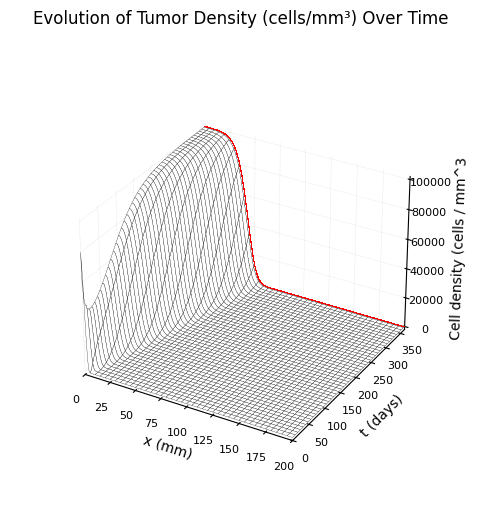

In [9]:
def plot3D(env):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(projection='3d')

    X = env.unwrapped.X
    nx = env.unwrapped.nx
    u = env.unwrapped.u
    simulation_days = env.unwrapped.simulationDays #temporal bound

    spatial = np.linspace(0, X, nx)
    temporal = np.linspace(0, simulation_days, simulation_days+1)
    data = u[:simulation_days+1, :]
    # print(spatial.shape)
    # print(temporal.shape)
    # print(data.shape)
    
    meshx, mesht = np.meshgrid(spatial, temporal)

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
      axis._axinfo['axisline']['linewidth'] = 1
      axis._axinfo['axisline']['color'] = "b"
      axis._axinfo['grid']['linewidth'] = 0.2
      axis._axinfo['grid']['linestyle'] = "--"
      axis._axinfo['grid']['color'] = "#d1d1d1"
      axis.set_pane_color((1,1,1))

    ax.set_title("Evolution of Tumor Density (cells/mm³) Over Time", pad=20)
    ax.set_xlabel("x (mm)", labelpad=5)
    ax.set_ylabel("t (days)", labelpad=5)
    ax.set_zlabel("Cell density (cells / mm^3", labelpad=8)
    ax.set_box_aspect(None, zoom=0.80)

    ax.tick_params(axis='x', which='major', labelsize=8, pad=5)
    ax.tick_params(axis='y', which='major', labelsize=8, pad=2)
    ax.tick_params(axis='z', which='major', labelsize=8, pad=3)
    ax.set_xlim(0, X)
    ax.set_ylim(0, simulation_days+1)

    ax.view_init(elev=30, azim=-60)

    # plot surface
    surf = ax.plot_surface(meshx, mesht, data, edgecolor="black", lw=0.2, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    
    # plot initial condition
    # t0 = np.zeros_like(spatial)
    # vals = data[0]
    # ax.plot(spatial, t0, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

    # plot death day
    if (env.unwrapped.cDeathDay is not None):
      t_death = np.full_like(spatial, env.unwrapped.cDeathDay)
      vals = data[env.unwrapped.cDeathDay]
      ax.plot(spatial, t_death, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

plot3D(envOpenLoop)